In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client


In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 24,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33507,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:35471,Total threads: 4
Dashboard: /proxy/32997/status,Memory: 21.33 GiB
Nanny: tcp://127.0.0.1:33419,


In [3]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'

session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

# temperature of meltwater using Gade line:
basal = 'accessom2-GPC015'
iceberg = 'accessom2-GPC018'
newbasal = 'accessom2-GPC021'


In [9]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC015/accessom2-GPC015/',
            '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC016/accessom2-GPC016/',
           '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC018/accessom2-GPC018/',
           '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC021/accessom2-GPC021/']
cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC015


0it [00:00, ?it/s]


Indexing experiment: accessom2-GPC016


0it [00:00, ?it/s]


Indexing experiment: accessom2-GPC018


0it [00:00, ?it/s]


Indexing experiment: accessom2-GPC021


100%|██████████| 16/16 [00:07<00:00,  2.11it/s]


16

In [10]:
expt = control
session = master_session

geolon_t = cc.querying.getvar(expt,'geolon_t',session, n=1)
geolat_t = cc.querying.getvar(expt,'geolat_t',session, n=1)

In [11]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map



In [12]:
def get_salt_snap(expt,session,start_time):
    salt_dummy = cc.querying.getvar(control, 'salt', master_session, n=1,frequency='1 monthly')
    #if start_time == 2150:
    #    # control snapshot
    #    filepathsalt = '/scratch/x77/cy8964/access-om2/archive/'+control+'/restart995/ocean/ocean_temp_salt.res.nc'
    #    filepathdzt = '/scratch/x77/cy8964/access-om2/archive/'+control+'/restart995/ocean/ocean_thickness.res.nc'
    #    nml_path = '/scratch/x77/cy8964/access-om2/archive/'+control+'/restart995/accessom2_restart.nml'
    if expt == basal:
        if start_time == 2150:
            outputno = 995
        elif start_time == 2151:
            outputno = 1002
        filepathsalt = '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC015/restarts/restart'+str(outputno)+'/ocean/ocean_temp_salt.res.nc'
        filepathdzt = '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC015/restarts/restart'+str(outputno)+'/ocean/ocean_thickness.res.nc'
        nml_path = '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC015/restarts/restart'+str(outputno)+'/accessom2_restart.nml'
    elif expt == newbasal:
        if start_time == 2150:
            outputno = 995
        elif start_time == 2151:
            outputno = 999
        filepathsalt = '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC021/restarts/restart'+str(outputno)+'/ocean/ocean_temp_salt.res.nc'
        filepathdzt = '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC021/restarts/restart'+str(outputno)+'/ocean/ocean_thickness.res.nc'
        nml_path = '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC021/restarts/restart'+str(outputno)+'/accessom2_restart.nml'
    elif expt == iceberg:
        outputno = (start_time-2150)*12+995
        if start_time >= 2158:
            outputno = outputno-2
        if start_time <=2156:
            filepathsalt = '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC018/restarts/restart'+str(outputno)+'/ocean/ocean_temp_salt.res.nc'
            filepathdzt = '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC018/restarts/restart'+str(outputno)+'/ocean/ocean_thickness.res.nc'
            nml_path = '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC018/restarts/restart'+str(outputno)+'/accessom2_restart.nml'
        else:
            filepathsalt = '/home/552/pc5520/access-om2/control/01deg_jra55v13_ryf9091_rerun_for_easterlies/archive/restart'+str(outputno)+'/ocean/ocean_temp_salt.res.nc'
            filepathdzt = '/home/552/pc5520/access-om2/control/01deg_jra55v13_ryf9091_rerun_for_easterlies/archive/restart'+str(outputno)+'/ocean/ocean_thickness.res.nc'
            nml_path = '/home/552/pc5520/access-om2/control/01deg_jra55v13_ryf9091_rerun_for_easterlies/archive/restart'+str(outputno)+'/accessom2_restart.nml'
    elif expt == control:
        if start_time == 2150:
            outputno = 995
        elif start_time == 2155:
            outputno = 1015
        filepathsalt = '/scratch/x77/cy8964/access-om2/archive/'+control+'/restart'+str(outputno)+'/ocean/ocean_temp_salt.res.nc'
        filepathdzt = '/scratch/x77/cy8964/access-om2/archive/'+control+'/restart'+str(outputno)+'/ocean/ocean_thickness.res.nc'
        nml_path = '/scratch/x77/cy8964/access-om2/archive/'+control+'/restart'+str(outputno)+'/accessom2_restart.nml'
        #else:
        #    print('restarts not found, control only has 5 year increments available')
    else:
        print('experiment not found')
    restart1t = xr.open_dataset(filepathsalt)
    nml = pd.read_table(nml_path, skiprows=None, header=None)
    print('Time details')
    print(nml)
    # only 1 time snapshot:
    salt_init = restart1t.salt[0,...]
    # fix coords:
    salt_init.coords['zaxis_1'] = salt_dummy['st_ocean'].values
    salt_init.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
    salt_init.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
    salt_init = salt_init.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
    #print(salt_init.Time.values)
    salt_init = salt_init.drop_vars('Time')

    restart1t = xr.open_dataset(filepathsalt)
    # only 1 time snapshot:
    temp_init = restart1t.temp[0,...]
    # fix coords:
    temp_init.coords['zaxis_1'] = salt_dummy['st_ocean'].values
    temp_init.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
    temp_init.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
    temp_init = temp_init.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
    #print(temp_init.Time.values)
    temp_init = temp_init.drop_vars('Time')
    restart1z = xr.open_dataset(filepathdzt)
    # only 1 time snapshot:
    dzt_init = restart1z.rho_dzt[0,...]
    # fix coords:
    dzt_init.coords['zaxis_1'] = salt_dummy['st_ocean'].values
    dzt_init.coords['yaxis_1'] = salt_dummy['yt_ocean'].values
    dzt_init.coords['xaxis_1'] = salt_dummy['xt_ocean'].values
    dzt_init = dzt_init.rename(({'zaxis_1':'st_ocean', 'yaxis_1':'yt_ocean', 'xaxis_1':'xt_ocean'}))
    #print(dzt_init.Time.values)
    dzt_init = dzt_init.drop_vars('Time')

    return salt_init, temp_init, dzt_init

In [15]:
# compute salt content change:

# J / kg / degC
c_p = 3992.1
rho0 = 1035.0
area = cc.querying.getvar(control, 'area_t', master_session, n=1).load()

print('expt = newbasal, year 2150 to 2151')
salt_init, temp_init,dzt_init = get_salt_snap(newbasal, basal_melt_session,2150)
salt_end, temp_end,dzt_end = get_salt_snap(newbasal, basal_melt_session,2151)


# salt in g/kg, multiply by kg in cell = rho0*area_t*dzt, gives g of salt, then divide by 1000 gives kg of salt.

# there is a factor of rho_0 in dzt so no need to include:
salt_content_change_newbasal = (((salt_end*dzt_end).sum('st_ocean') - (salt_init*dzt_init).sum('st_ocean'))*area).sum()
print('Net salt content change over this period =',salt_content_change_newbasal.values/1e3/1e12,'x 10^12 kg')

#shelf value
salt_shelf, shelf_mask = shelf_mask_isobath((((salt_end*dzt_end).sum('st_ocean') - (salt_init*dzt_init).sum('st_ocean'))*area))
salt_shelf = salt_shelf.sum()
print('Net salt content change over shelf in this period =',salt_shelf.values/1e3/1e12,'x 10^12 kg')

expt = newbasal, year 2150 to 2151
Time details
                                                 0
0                                 &DO_NOT_EDIT_NML
1   FORCING_CUR_DATE        = 1900-01-01T00:00:00,
2            EXP_CUR_DATE    = 2150-01-01T00:00:00
3                                                /
Time details
                                                 0
0                                 &DO_NOT_EDIT_NML
1   FORCING_CUR_DATE        = 1900-01-01T00:00:00,
2            EXP_CUR_DATE    = 2151-01-01T00:00:00
3                                                /
Net salt content change over this period = -4.714728912970463 x 10^12 kg
Net salt content change over shelf in this period = 23.450591325592928 x 10^12 kg


In [14]:
# compute salt content change:

# J / kg / degC
c_p = 3992.1
rho0 = 1035.0
area = cc.querying.getvar(control, 'area_t', master_session, n=1).load()

print('expt = basal, year 2150 to 2151')
salt_init, temp_init,dzt_init = get_salt_snap(basal, basal_melt_session,2150)
salt_end, temp_end,dzt_end = get_salt_snap(basal, basal_melt_session,2151)


# salt in g/kg, multiply by kg in cell = rho0*area_t*dzt, gives g of salt, then divide by 1000 gives kg of salt.

# there is a factor of rho_0 in dzt so no need to include:
salt_content_change_basal = (((salt_end*dzt_end).sum('st_ocean') - (salt_init*dzt_init).sum('st_ocean'))*area).sum()
print('Net salt content change over this period =',salt_content_change_basal.values/1e3/1e12,'x 10^12 kg')

#shelf value
salt_shelf, shelf_mask = shelf_mask_isobath((((salt_end*dzt_end).sum('st_ocean') - (salt_init*dzt_init).sum('st_ocean'))*area))
salt_shelf = salt_shelf.sum()
print('Net salt content change over shelf in this period =',salt_shelf.values/1e3/1e12,'x 10^12 kg')

expt = basal, year 2150 01-01 to 01-07
Time details
                                                 0
0                                 &DO_NOT_EDIT_NML
1   FORCING_CUR_DATE        = 1900-01-01T00:00:00,
2            EXP_CUR_DATE    = 2150-01-01T00:00:00
3                                                /
Time details
                                                 0
0                                 &DO_NOT_EDIT_NML
1   FORCING_CUR_DATE        = 1900-01-01T00:00:00,
2            EXP_CUR_DATE    = 2151-01-01T00:00:00
3                                                /
Net salt content change over this period = -54.14788031411367 x 10^12 kg
Net salt content change over shelf in this period = -15.161936645020406 x 10^12 kg


In [13]:
# compute salt content change:

# J / kg / degC
c_p = 3992.1
rho0 = 1035.0
area = cc.querying.getvar(control, 'area_t', master_session, n=1).load()

print('expt = control, years 2150 to 2155')
salt_init, temp_init,dzt_init = get_salt_snap(control, master_session,2150)
salt_end, temp_end,dzt_end = get_salt_snap(control, master_session,2155)


# salt in g/kg, multiply by kg in cell = rho0*area_t*dzt, gives g of salt, then divide by 1000 gives kg of salt.

# there is a factor of rho_0 in dzt so no need to include:
salt_content_change_control = (((salt_end*dzt_end).sum('st_ocean') - (salt_init*dzt_init).sum('st_ocean'))*area).sum()
print('Net salt content change over this period =',salt_content_change_control.values/1e3/1e12,'x 10^12 kg')

#shelf value
salt_shelf, shelf_mask = shelf_mask_isobath((((salt_end*dzt_end).sum('st_ocean') - (salt_init*dzt_init).sum('st_ocean'))*area))
salt_shelf = salt_shelf.sum()
print('Net salt content change over shelf in this period =',salt_shelf.values/1e3/1e12,'x 10^12 kg')

expt = control, years 2150 to 2155
Time details
                                                 0
0                                 &DO_NOT_EDIT_NML
1   FORCING_CUR_DATE        = 1900-01-01T00:00:00,
2            EXP_CUR_DATE    = 2150-01-01T00:00:00
3                                                /
Time details
                                                 0
0                                 &DO_NOT_EDIT_NML
1   FORCING_CUR_DATE        = 1900-01-01T00:00:00,
2            EXP_CUR_DATE    = 2155-01-01T00:00:00
3                                                /
Net salt content change over this period = -0.5121560807162145 x 10^12 kg
Net salt content change over shelf in this period = -0.010199346850187585 x 10^12 kg


# Compare terms

In [16]:
### Actual KG of SALT budget

def get_salt_budget_terms(expt, session, start_time, end_time, lat_north = -59):
    '''
    Gets surface water-mass transformation rates, copied from cosima recipes
    https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Surface_Water_Mass_Transformation.ipynb
    and modified to add melt, river, basalmix and icbmix and output these FW fluxes
    '''
    ## getvar all required variables
    #SST = cc.querying.getvar(expt,'surface_temp',session,frequency='1 monthly',start_time=start_time,end_time=end_time) - 273.15 # SST - conservative temperature in K (sheck this is the case for your run)
    #SSS_PSU = cc.querying.getvar(expt,'surface_salt',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # SSS - practical salinity (not absolute)
    #pme_river = cc.querying.getvar(expt,'pme_river',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of precip - evap + river
    #melt = cc.querying.getvar(expt,'melt',session,frequency='1 monthly',start_time=start_time,end_time=end_time) #
    #river = cc.querying.getvar(expt,'river',session,frequency='1 monthly',start_time=start_time,end_time=end_time) #
    # Note that is sfc_salt_flux_ice is not saved, you can use sfc_salt_flux_ice = 0.005*melt instead
    sfc_salt_flux_ice = cc.querying.getvar(expt,'sfc_salt_flux_ice',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from ice formation/melt
    sfc_salt_flux_restore = cc.querying.getvar(expt,'sfc_salt_flux_restore',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from surface salinity restoring
    sfc_salt_flux_coupler = cc.querying.getvar(expt,'sfc_salt_flux_coupler',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from surface salinity restoring

    varlist = cc.querying.get_variables(session, expt)
    if varlist['name'].str.contains('salt_basalmix').any():
        salt_basalmix = cc.querying.getvar(expt,'salt_basalmix',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from basal flux
    else:
        salt_basalmix = xr.zeros_like(sfc_salt_flux_ice)
        
    if varlist['name'].str.contains('salt_icbmix').any():
        salt_icbmix = cc.querying.getvar(expt,'salt_icbmix',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from basal flux
    else:
        salt_icbmix = xr.zeros_like(sfc_salt_flux_ice)
        
    ## getvar the components of the net surface heat fux instead of the net_surface_heating variable
    #sfc_hflux_from_runoff = cc.querying.getvar(expt,'sfc_hflux_from_runoff',session,frequency='1 monthly') # W/m2
    #sfc_hflux_coupler = cc.querying.getvar(expt,'sfc_hflux_coupler',session,frequency='1 monthly') # W/m2
    #sfc_hflux_pme = cc.querying.getvar(expt,'sfc_hflux_pme',session,frequency='1 monthly') # W/m2
    #frazil_3d_int_z = cc.querying.getvar(expt,'frazil_3d_int_z',session,frequency='1 monthly') # W/m2
    #geolon_t = cc.querying.getvar(expt,'geolon_t',session, n=1)
    #geolat_t = cc.querying.getvar(expt,'geolat_t',session, n=1)
    ## slice for time and latitudinal constraints
    time_slice = slice(start_time,end_time)
    lat_slice = slice(-90,lat_north)
    #SST = SST.sel(time=time_slice, yt_ocean=lat_slice)
    #SSS_PSU = SSS_PSU.sel(time=time_slice, yt_ocean=lat_slice)
    #pme_river = pme_river.sel(time=time_slice, yt_ocean=lat_slice)
    #melt = melt.sel(time=time_slice, yt_ocean=lat_slice)
    #river = river.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_salt_flux_ice = sfc_salt_flux_ice.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_salt_flux_restore = sfc_salt_flux_restore.sel(time=time_slice, yt_ocean=lat_slice)
    sfc_salt_flux_coupler = sfc_salt_flux_coupler.sel(time=time_slice, yt_ocean=lat_slice)
    salt_basalmix = salt_basalmix.sel(time=time_slice, yt_ocean=lat_slice)
    salt_icbmix = salt_icbmix.sel(time=time_slice, yt_ocean=lat_slice)
    
    #sfc_hflux_from_runoff = sfc_hflux_from_runoff.sel(time=time_slice, yt_ocean=lat_slice)
    #sfc_hflux_coupler = sfc_hflux_coupler.sel(time=time_slice, yt_ocean=lat_slice)
    #sfc_hflux_pme = sfc_hflux_pme.sel(time=time_slice, yt_ocean=lat_slice)
    #frazil_3d_int_z = frazil_3d_int_z.sel(time=time_slice, yt_ocean=lat_slice)
    # lon_t = geolon_t.sel(yt_ocean=lat_slice)
    # lat_t = geolat_t.sel(yt_ocean=lat_slice)
    # ## extract coordinate arrays
    # yt_ocean = SSS_PSU.yt_ocean.values
    # xt_ocean = SSS_PSU.xt_ocean.values
    #st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=1).load()
    time_monthly = sfc_salt_flux_ice.time.values
    ## construct an xarray of days per month (check this is relevant to your run), simple modification if non integer number of years analysed
    start_month = int(start_time[5:7])
    end_month = int(end_time[5:7])
    
    n_years = int(len(sfc_salt_flux_ice.time)/12)
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

    if start_month != 1:
        months_offset_noleap = np.append(months_standard_noleap[(start_month-1):],months_standard_noleap[:(start_month-1)])
    else:
        months_offset_noleap = months_standard_noleap
    days_per_month = xr.DataArray(np.tile(months_offset_noleap, n_years), coords = [time_monthly], dims = ['time'], name = 'days per month')
    ## compute net surface heat flux from its component terms
    #net_surface_heating = sfc_hflux_from_runoff+ sfc_hflux_coupler+ sfc_hflux_pme+ frazil_3d_int_z # W/m2
    ## now I use some TEOS-10 gsw functions to compute absolute salinity, then potential density fields
    ## these are numpy functions, if you have memory errors this is a good step to check (though I have found
    ## this works on the VDI for 0.1 degree data, might be issues for very long time periods)
    #depth = -st_ocean[0].values # st_ocean value of the uppermost cell
    #depth_tile = (lat_t*0+1)*depth
    #pressure = xr.DataArray(p_from_z(depth_tile,lat_t), coords = [yt_ocean, xt_ocean], dims = ['yt_ocean', 'xt_ocean'], name = 'pressure', attrs = {'units':'dbar'})
    # convert units to absolute salinity 
    #SSS = xr.DataArray(SA_from_SP(SSS_PSU,pressure,lon_t,lat_t), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', attrs = {'units':'Absolute Salinity (g/kg)'})
    ## SST is already saved as conservative temperature in this run, if you are working with an older run with potential 
    ## temperature saved, conversion will be required (make sure you work with C not K)
    # SST = xr.DataArray(CT_from_pt(SSS_AS,SST_PT), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface temperature', attrs = {'units':'Conservative Temperature (C)'})
    # compute potential density referenced to 1000dbar (or referenced otherwise, depending on your purpose)
    #pot_rho_1 = xr.DataArray(sigma1(SSS, SST), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'potential density ref 1000dbar', attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})
    #pot_rho_1 = pot_rho_1.load()
    # Compute salt transformation (no density binning)
    #haline_contraction = xr.DataArray(beta(SSS, SST, pressure), coords = [time_monthly, yt_ocean, xt_ocean], dims = ['time','yt_ocean', 'xt_ocean'], name = 'saline contraction coefficient (constant conservative temp)', attrs = {'units':'kg/g'})
    # Note that the salt fluxes have units of (kg of salt)/m^2/s, while beta has
    # units of kg / (g of salt), so we need to multiply the salt fluxes by 1000,
    # the fresh water flux `pme_river` has units of (kg of water)/(m²/s) and needs
    # to be multiplied by SSS to convert to (g of salt)/m^2/s
    # This gives units of (kg of water)/m² for the salt_transformation but it
    # will later be divided by time and density and be in m/s:
    #salt_transformation = haline_contraction*(SSS*pme_river-(sfc_salt_flux_ice + sfc_salt_flux_restore + salt_basalmix + salt_icbmix)*1000)*days_per_month #! before was PSU, why?
    #salt_transformation = salt_transformation.load()
    
    #haline_contraction = haline_contraction.load()
    
#     pme_river_salt_trans = haline_contraction*SSS*pme_river*days_per_month
#     pme_river_salt_trans = pme_river_salt_trans.load()

#     river = haline_contraction*SSS*river*days_per_month
#     river = river.load()

#     melt = haline_contraction*SSS*melt*days_per_month
#     melt = melt.load()
    
    #ice = haline_contraction*sfc_salt_flux_ice*1000*days_per_month
    ice = sfc_salt_flux_ice*days_per_month
    ice = ice.load()
    
    #restore = haline_contraction*sfc_salt_flux_restore*1000*days_per_month
    restore = sfc_salt_flux_restore*days_per_month
    restore = restore.load()
    
    #basal = haline_contraction*salt_basalmix*1000*days_per_month
    basal = salt_basalmix*days_per_month
    basal = basal.load()
    
    #icb = haline_contraction*salt_icbmix*1000*days_per_month
    icb = salt_icbmix*days_per_month
    icb = icb.load()
    
    #coupler = haline_contraction*sfc_salt_flux_coupler*days_per_month*1000
    coupler = sfc_salt_flux_coupler*days_per_month
    coupler = coupler.load()
    
    
    
    #return pme_river_salt_trans, river, melt, ice, restore, basal, icb, coupler, days_per_month
    return ice, restore, basal, icb, days_per_month

0
[[-1.09009675e+04 -7.46843630e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]]


Text(0.5, 1.0, 'Global salt budget fluxes (kg/s)')

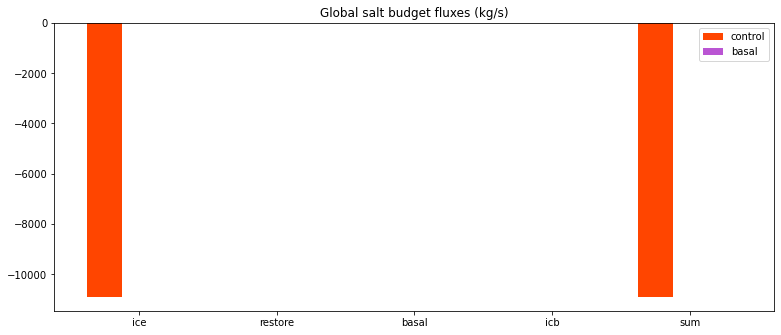

In [17]:
## Global integral of salt

start_time = '2150-01-01'
end_time = '2151-01-01'
session = master_session
expt = control
lat_north = 90
area_t = cc.querying.getvar(expt, 'area_t', session, n=1).sel(yt_ocean = slice(-90,lat_north))

bar_plot = np.zeros((3,5))

for i in np.arange(1): 
    print(i)
    expt = [control,basal,iceberg][i]
    session = [master_session,basal_melt_session,basal_melt_session][i]
    
    ice,restore,basalh,icb,days_per_month = get_salt_budget_terms(expt, session, start_time, end_time, lat_north)
    ndays = days_per_month.sum().values
    bar_plot[i,:]=[#(salt_transformation*area_t).sum()/ndays,
                   #(pme_river_salt_trans*area_t).sum()/ndays,
                   (ice*area_t).sum()/ndays,
                   (restore*area_t).sum()/ndays,
                   (basalh*area_t).sum()/ndays,
                   (icb*area_t).sum()/ndays,
                    0
                  ]
    print(bar_plot)
bar_plot[:,4]=bar_plot[:,0]+bar_plot[:,1]+bar_plot[:,2]+bar_plot[:,3]
X = np.arange(5)
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, bar_plot[0,:], color = 'orangered', width = 0.25)
ax.bar(X + 0.25, bar_plot[1,:], color = 'mediumorchid', width = 0.25)
ax.bar(X + 0.50, bar_plot[2,:], color = 'cornflowerblue', width = 0.25)

ax.legend(labels=['control', 'basal'])
plt.xticks(X+0.25, ('ice','restore','basal','icb','sum'))
plt.title('Global salt budget fluxes (kg/s)')

In [18]:
## Do manually for basal since kernel keeps dying
expt = control
session = master_session
start_time = '2150-01-01'
end_time = '2155-01-01'
lat_north = 90
area_t = cc.querying.getvar(expt, 'area_t', session, n=1).sel(yt_ocean = slice(-90,lat_north))
time_slice = slice(start_time,end_time)
lat_slice = slice(-90,lat_north)

sfc_salt_flux_ice = cc.querying.getvar(expt,'sfc_salt_flux_ice',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from ice formation/melt
sfc_salt_flux_restore = cc.querying.getvar(expt,'sfc_salt_flux_restore',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from surface salinity restoring

sfc_salt_flux_ice = sfc_salt_flux_ice.sel(time=time_slice, yt_ocean=lat_slice)
sfc_salt_flux_restore = sfc_salt_flux_restore.sel(time=time_slice, yt_ocean=lat_slice)

days_in_month = sfc_salt_flux_ice.time.dt.days_in_month

In [19]:
%%time

ice = sfc_salt_flux_ice*days_in_month*area_t
restore = sfc_salt_flux_restore*days_in_month*area_t

ice = ice.sum()*24*3600/1e12
ice_control = ice.load()
print(ice_control)

restore = restore.sum()*24*3600/1e12
restore_control = restore.load()
print(restore_control)

<xarray.DataArray ()>
array(-0.51200671)
<xarray.DataArray ()>
array(-0.00012473)
CPU times: user 6.93 s, sys: 453 ms, total: 7.38 s
Wall time: 11.5 s


In [20]:
## Do manually for basal since kernel keeps dying
expt = basal
session = basal_melt_session
start_time = '2150-01-01'
end_time = '2151-01-01'
lat_north = 90
area_t = cc.querying.getvar(expt, 'area_t', session, n=1).sel(yt_ocean = slice(-90,lat_north))
time_slice = slice(start_time,end_time)
lat_slice = slice(-90,lat_north)

sfc_salt_flux_ice = cc.querying.getvar(expt,'sfc_salt_flux_ice',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from ice formation/melt
sfc_salt_flux_restore = cc.querying.getvar(expt,'sfc_salt_flux_restore',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from surface salinity restoring
salt_basalmix = cc.querying.getvar(expt,'salt_basalmix',session,frequency='1 monthly',start_time=start_time,end_time=end_time)

sfc_salt_flux_ice = sfc_salt_flux_ice.sel(time=time_slice, yt_ocean=lat_slice)
sfc_salt_flux_restore = sfc_salt_flux_restore.sel(time=time_slice, yt_ocean=lat_slice)
salt_basalmix = salt_basalmix.sel(time=time_slice, yt_ocean=lat_slice)

days_in_month = sfc_salt_flux_ice.time.dt.days_in_month

In [21]:
%%time

ice = sfc_salt_flux_ice*days_in_month*area_t
restore = sfc_salt_flux_restore*days_in_month*area_t
basalh = salt_basalmix*days_in_month*area_t

ice = ice.sum()*24*3600/1e12
ice_basal = ice.load()
print(ice_basal)

restore = restore.sum()*24*3600/1e12
restore_basal = restore.load()
print(restore_basal)

basalh = basalh.sum()*24*3600/1e12
basalh = basalh.load()
print(basalh)

<xarray.DataArray ()>
array(-4.89643127)
<xarray.DataArray ()>
array(-1.96333661e-05)
<xarray.DataArray ()>
array(-49.25142012)
CPU times: user 51.1 s, sys: 2.97 s, total: 54.1 s
Wall time: 1min 12s


In [22]:
## Do manually for basal since kernel keeps dying
expt = newbasal
session = basal_melt_session
start_time = '2150-01-01'
end_time = '2151-01-01'
lat_north = 90
area_t = cc.querying.getvar(expt, 'area_t', session, n=1).sel(yt_ocean = slice(-90,lat_north))
time_slice = slice(start_time,end_time)
lat_slice = slice(-90,lat_north)

sfc_salt_flux_ice = cc.querying.getvar(expt,'sfc_salt_flux_ice',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from ice formation/melt
sfc_salt_flux_restore = cc.querying.getvar(expt,'sfc_salt_flux_restore',session,frequency='1 monthly',start_time=start_time,end_time=end_time) # mass flux of salt from surface salinity restoring

sfc_salt_flux_ice = sfc_salt_flux_ice.sel(time=time_slice, yt_ocean=lat_slice)
sfc_salt_flux_restore = sfc_salt_flux_restore.sel(time=time_slice, yt_ocean=lat_slice)

days_in_month = sfc_salt_flux_ice.time.dt.days_in_month

In [23]:
%%time

ice = sfc_salt_flux_ice*days_in_month*area_t
restore = sfc_salt_flux_restore*days_in_month*area_t

ice = ice.sum()*24*3600/1e12
ice_newbasal = ice.load()
print(ice_newbasal)

restore = restore.sum()*24*3600/1e12
restore_newbasal = restore.load()
print(restore_newbasal)

<xarray.DataArray ()>
array(-4.71470035)
<xarray.DataArray ()>
array(-2.53621846e-05)
CPU times: user 2.52 s, sys: 242 ms, total: 2.76 s
Wall time: 4.16 s


In [24]:
sum_control = restore_control + ice_control
sum_basal = restore_basal + ice_basal + basalh
sum_newbasal = restore_newbasal + ice_newbasal

In [29]:
salt_change_control = salt_content_change_control/1e3/1e12
salt_change_basal = salt_content_change_basal/1e3/1e12
salt_change_newbasal = salt_content_change_newbasal/1e3/1e12

Text(0, 0.5, 'Salt content change (x10^12 kg)')

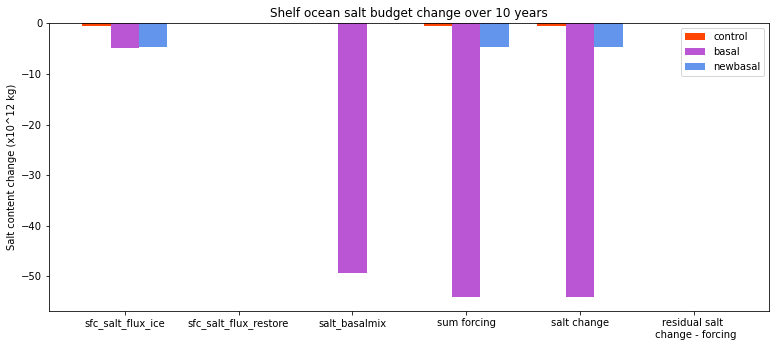

In [30]:
### manually add data (2150-59, shelf) since kernel died when i did it all at once
# columns are ice, restore, basal, icb, 0 (to be summed), salt change, 0 (to be calc. from residual)
# rows are control (can be computed using above salt budget function), basal (GPC015), iceberg (GPC018)
# salt change function in notebook Salt_change.ipynb
ndays = 365*10 #days_in_month.sum()
bar_plot = np.array([[ice_control ,restore_control ,0     , sum_control,salt_change_control ,salt_change_control-sum_control],
                     [ice_basal   ,restore_basal   ,basalh,sum_basal   ,salt_change_basal   ,salt_change_basal-sum_basal],
                     [ice_newbasal,restore_newbasal,0     ,sum_newbasal,salt_change_newbasal,salt_change_newbasal-sum_newbasal]])

#ar_plot[:,4]=bar_plot[:,0]+bar_plot[:,1]+bar_plot[:,2]+bar_plot[:,3]
#ar_plot[:,5]=bar_plot[:,]-bar_plot[:,4]

X = np.arange(6)
fig = plt.figure(figsize = (10,4))
ax = fig.add_axes([0,0,1,1])

ax.bar(X + 0.00, bar_plot[0,:], color = 'orangered', width = 0.25)
ax.bar(X + 0.25, bar_plot[1,:], color = 'mediumorchid', width = 0.25)
ax.bar(X + 0.50, bar_plot[2,:], color = 'cornflowerblue', width = 0.25)

ax.legend(labels=['control', 'basal','newbasal'])
plt.xticks(X+0.25, ('sfc_salt_flux_ice','sfc_salt_flux_restore','salt_basalmix','sum forcing','salt change','residual salt \n change - forcing'))
plt.title('Shelf ocean salt budget change over 10 years')
plt.ylabel('Salt content change (x10^12 kg)')

In [27]:
ice_newbasal

<xarray.DataArray ()>
array(-4.71470035)

In [28]:
salt_change_newbasal

<xarray.DataArray ()>
array(-4.71472891e+15)